In [4]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import numpy as np
import os
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from PIL import Image
# from google.colab import drive
import json
from tqdm.notebook import tqdm
from itertools import product

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!unzip /content/sample_data/dataset_hackaton_2024.zip -d /content/data/

Archive:  /content/sample_data/dataset_hackaton_2024.zip
replace /content/data/dataset_hackaton_2024/test/inappropriate/_Aj2vHGWN4A.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Defining contstants

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 8
CLASS_NAMES = {
    'safe': [0, 1],
    'inappropriate': [1, 0]
}

DATA_ROOT = '/content/data/dataset_hackaton_2024'

## Define the model

In [ ]:
vgg19 = torchvision.models.vgg19(torchvision.models.VGG19_Weights.IMAGENET1K_V1)
# redefine the classifier
params_list = [nn.Linear(25088, 4096, bias=True),
                           nn.ReLU(inplace=True),
                           nn.BatchNorm1d(4096),
                           nn.Dropout(0.5),
                           nn.Linear(4096, 4096, bias=True),
                           nn.ReLU(inplace=True),
                           nn.BatchNorm1d(4096),
                           nn.Dropout(0.5),
                           nn.Linear(4096, 1000, bias=True),
                           nn.BatchNorm1d(1000),
                           nn.ReLU(inplace=True),
                           nn.Dropout(0.5),
                           nn.Linear(1000, 2, bias=True)]
class Model(nn.Module):
    def __init__(self, params, freeze: bool, vgg):
        super().__init__()
        self.extractor = vgg.features
        for param in self.extractor.parameters():
            param.requires_grad = not freeze
        self.flatten = nn.Flatten(1, 3)
        self.BN = nn.BatchNorm1d(25088)
        self.classifier = nn.Sequential(*params)
    def forward(self, x):
        features = self.extractor(x)
        flattened = self.flatten(features)
        classes = self.classifier(self.BN(flattened))
        return torch.nn.functional.softmax(classes)


model = Model(params_list, True, vgg19)

#### Augments and utility functoins

In [ ]:
preprocessors = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]) # inference time

augments = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE*1.2)),
    transforms.RandomRotation(15),
    transforms.RandomCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]) #train time


#### Define dataset

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, root, transform, mode) -> None:
        self.mode = mode
        self.transforms = transform
        self.files = list()
        self.labels = list()
        image_set_name = 'train'
        if self.mode == 'test':
            image_set_name = 'test'
        if self.mode == 'valid':
            image_set_name = 'valid'

        dir = os.path.join(root, image_set_name)
        for class_dir in os.listdir(dir):
            path_to_all_calss_files = os.path.join(dir, class_dir)
            for filename in os.listdir(path_to_all_calss_files):
                full_path = os.path.join(path_to_all_calss_files, filename)
                if os.path.isfile(full_path):
                    self.files.append(full_path)
                    self.labels.append(CLASS_NAMES[class_dir.lower()])

        assert len(self.labels) == len(
            self.files), "each file should have a label"

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        img = self.transforms(img)
        labels = self.labels[index % len(self.labels)]

        return (img, torch.tensor(labels, dtype=torch.float32))

    def __len__(self):
        return len(self.files)

In [ ]:
def plot_history(history, title:str):
    plt.figure(figsize=(12, 8))
    epochs = len(history['train'])
    plt.plot(range(epochs), history['train'], label = 'train')
    plt.plot(range(epochs), history['val'], label = 'val')
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
def show_image(img):
  if isinstance(img, torch.Tensor):
      plt.imshow(img.view(-1, IMAGE_SIZE, IMAGE_SIZE).permute(1,
                                                              2, 0).detach().cpu().numpy())
  elif isinstance(img, str):
      img = Image.open(img)
      plt.imshow(img)
  else:
      plt.imshow(img)
  plt.show()

In [ ]:
train_dataset = ImageDataset(DATA_ROOT, augments, 'train')
valid_dataset = ImageDataset(DATA_ROOT, preprocessors, 'valid')
test_dataset = ImageDataset(DATA_ROOT, preprocessors, 'test')

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
mse_loss = nn.MSELoss()
bce_loss = nn.CrossEntropyLoss()

In [ ]:
def train(model, epochs, loss_function, frozen,  lr):
    best_val_loss = float('inf')
    template = '[{:3}/{:3}]\ttrain loss: {:2.3f}\tval loss: {:2.3f}'
    history = {'train':list(), 'val':list()}
    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda'
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in tqdm(range(epochs)):
        model.train()
        epoch_train, epoch_val = 0, 0
        for batch in train_dataloader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(images)
            # print([x.item() for x in preds])
            loss = loss_function(preds, labels)
            loss.backward()
            optimizer.step()

            epoch_train+=loss
        epoch_train /= len(train_dataloader)
        history['train'].append(epoch_train.item())

        model.eval()
        for batch in valid_dataloader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                preds = model(images)
                # print(preds)
                # show_image(images[0])
                loss = loss_function(preds, labels)

            epoch_val+=loss
        epoch_val /= len(valid_dataloader)
        history['val'].append(epoch_val.item())
        if(epoch_val<=best_val_loss):
            best_val_loss = epoch_val
            arg1 = "frozen" if frozen else "unfreezed"
            arg2 = "MSE" if isinstance(loss_function, torch.nn.modules.loss.MSELoss) else "CrossEntropy"
            torch.save(model.state_dict(), f'/content/{arg1}_{arg2}_lr{lr}_best.pt')
        print(template.format(epoch+1, epochs, epoch_train, epoch_val))
    return history

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


  0%|          | 0/25 [00:00<?, ?it/s]

<ipython-input-30-def6c46ffd6d>:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(classes)


[  1/ 25]	train loss: 0.280	val loss: 0.150
[  2/ 25]	train loss: 0.364	val loss: 0.425
[  3/ 25]	train loss: 0.348	val loss: 0.500
[  4/ 25]	train loss: 0.330	val loss: 0.446
[  5/ 25]	train loss: 0.216	val loss: 0.425
[  6/ 25]	train loss: 0.292	val loss: 0.425
[  7/ 25]	train loss: 0.347	val loss: 0.400
[  8/ 25]	train loss: 0.267	val loss: 0.400
[  9/ 25]	train loss: 0.250	val loss: 0.350
[ 10/ 25]	train loss: 0.268	val loss: 0.325
[ 11/ 25]	train loss: 0.247	val loss: 0.375
[ 12/ 25]	train loss: 0.308	val loss: 0.425
[ 13/ 25]	train loss: 0.373	val loss: 0.525
[ 14/ 25]	train loss: 0.367	val loss: 0.450
[ 15/ 25]	train loss: 0.403	val loss: 0.525
[ 16/ 25]	train loss: 0.380	val loss: 0.450
[ 17/ 25]	train loss: 0.390	val loss: 0.525
[ 18/ 25]	train loss: 0.377	val loss: 0.475
[ 19/ 25]	train loss: 0.385	val loss: 0.575
[ 20/ 25]	train loss: 0.392	val loss: 0.450
[ 21/ 25]	train loss: 0.392	val loss: 0.450
[ 22/ 25]	train loss: 0.307	val loss: 0.225
[ 23/ 25]	train loss: 0.314	val 

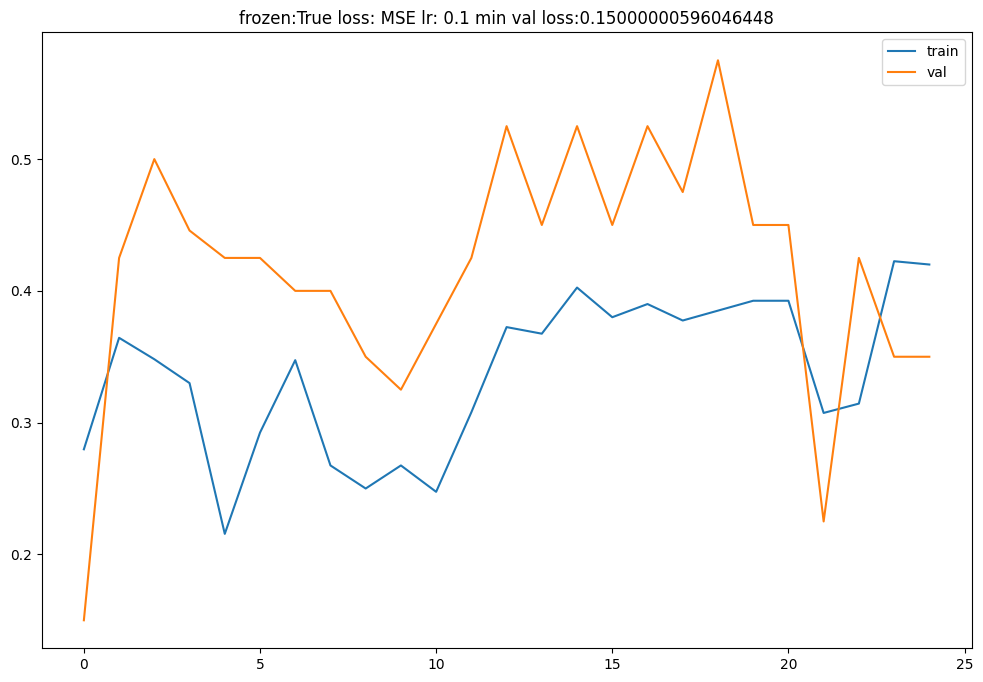

  0%|          | 0/25 [00:00<?, ?it/s]

[  1/ 25]	train loss: 0.475	val loss: 0.350
[  2/ 25]	train loss: 0.448	val loss: 0.350
[  3/ 25]	train loss: 0.357	val loss: 0.250
[  4/ 25]	train loss: 0.335	val loss: 0.325
[  5/ 25]	train loss: 0.363	val loss: 0.500
[  6/ 25]	train loss: 0.365	val loss: 0.350
[  7/ 25]	train loss: 0.318	val loss: 0.300
[  8/ 25]	train loss: 0.297	val loss: 0.300
[  9/ 25]	train loss: 0.327	val loss: 0.275
[ 10/ 25]	train loss: 0.300	val loss: 0.300
[ 11/ 25]	train loss: 0.295	val loss: 0.450
[ 12/ 25]	train loss: 0.357	val loss: 0.400
[ 13/ 25]	train loss: 0.362	val loss: 0.425
[ 14/ 25]	train loss: 0.345	val loss: 0.400
[ 15/ 25]	train loss: 0.313	val loss: 0.375
[ 16/ 25]	train loss: 0.277	val loss: 0.325
[ 17/ 25]	train loss: 0.280	val loss: 0.350
[ 18/ 25]	train loss: 0.296	val loss: 0.425
[ 19/ 25]	train loss: 0.250	val loss: 0.575
[ 20/ 25]	train loss: 0.242	val loss: 0.250
[ 21/ 25]	train loss: 0.252	val loss: 0.250
[ 22/ 25]	train loss: 0.280	val loss: 0.275
[ 23/ 25]	train loss: 0.270	val 

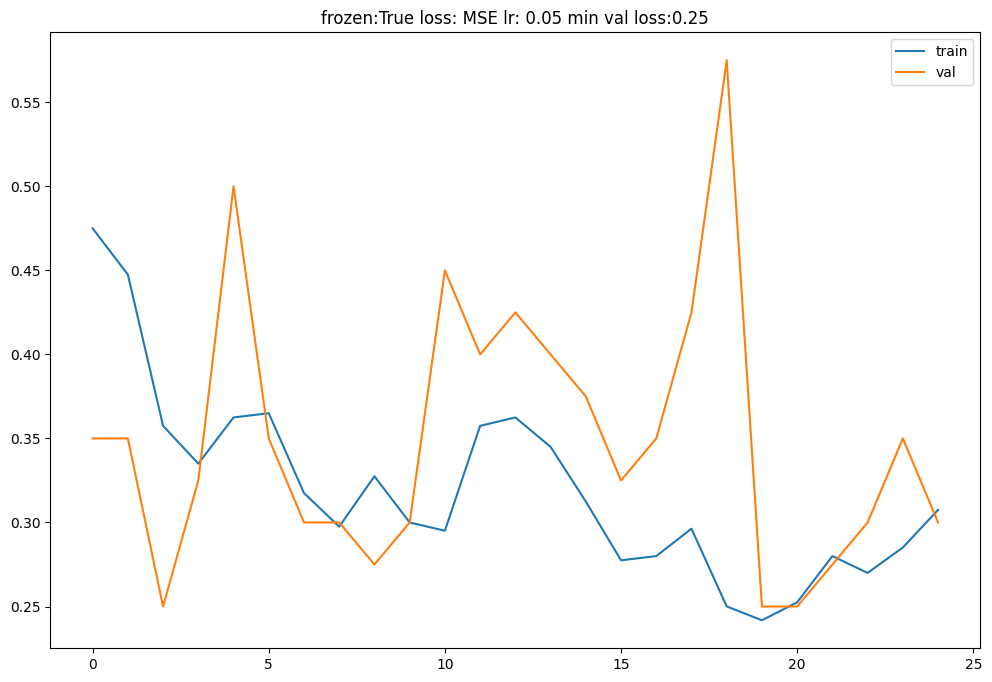

  0%|          | 0/25 [00:00<?, ?it/s]

[  1/ 25]	train loss: 0.305	val loss: 0.325
[  2/ 25]	train loss: 0.275	val loss: 0.300
[  3/ 25]	train loss: 0.293	val loss: 0.350
[  4/ 25]	train loss: 0.317	val loss: 0.325
[  5/ 25]	train loss: 0.290	val loss: 0.300
[  6/ 25]	train loss: 0.317	val loss: 0.300
[  7/ 25]	train loss: 0.330	val loss: 0.250
[  8/ 25]	train loss: 0.280	val loss: 0.325
[  9/ 25]	train loss: 0.300	val loss: 0.350
[ 10/ 25]	train loss: 0.283	val loss: 0.350
[ 11/ 25]	train loss: 0.282	val loss: 0.300
[ 12/ 25]	train loss: 0.304	val loss: 0.300
[ 13/ 25]	train loss: 0.275	val loss: 0.325
[ 14/ 25]	train loss: 0.275	val loss: 0.325
[ 15/ 25]	train loss: 0.270	val loss: 0.300
[ 16/ 25]	train loss: 0.310	val loss: 0.350
[ 17/ 25]	train loss: 0.287	val loss: 0.350
[ 18/ 25]	train loss: 0.287	val loss: 0.333
[ 19/ 25]	train loss: 0.283	val loss: 0.275
[ 20/ 25]	train loss: 0.265	val loss: 0.325
[ 21/ 25]	train loss: 0.290	val loss: 0.350
[ 22/ 25]	train loss: 0.297	val loss: 0.325
[ 23/ 25]	train loss: 0.317	val 

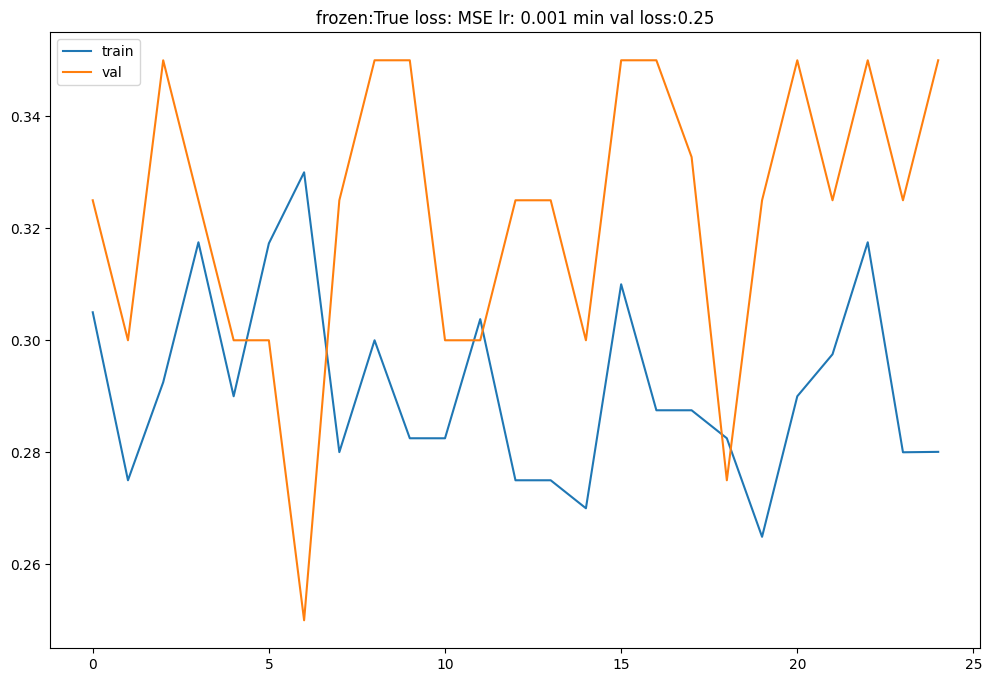

  0%|          | 0/25 [00:00<?, ?it/s]

[  1/ 25]	train loss: 0.457	val loss: nan
[  2/ 25]	train loss: 0.495	val loss: nan
[  3/ 25]	train loss: 0.520	val loss: nan
[  4/ 25]	train loss: 0.477	val loss: nan
[  5/ 25]	train loss: nan	val loss: nan
[  6/ 25]	train loss: nan	val loss: nan
[  7/ 25]	train loss: nan	val loss: nan
[  8/ 25]	train loss: nan	val loss: nan
[  9/ 25]	train loss: nan	val loss: nan
[ 10/ 25]	train loss: nan	val loss: nan
[ 11/ 25]	train loss: nan	val loss: nan
[ 12/ 25]	train loss: nan	val loss: nan
[ 13/ 25]	train loss: nan	val loss: nan
[ 14/ 25]	train loss: nan	val loss: nan
[ 15/ 25]	train loss: nan	val loss: nan
[ 16/ 25]	train loss: nan	val loss: nan
[ 17/ 25]	train loss: nan	val loss: nan
[ 18/ 25]	train loss: nan	val loss: nan
[ 19/ 25]	train loss: nan	val loss: nan
[ 20/ 25]	train loss: nan	val loss: nan
[ 21/ 25]	train loss: nan	val loss: nan
[ 22/ 25]	train loss: nan	val loss: nan
[ 23/ 25]	train loss: nan	val loss: nan
[ 24/ 25]	train loss: nan	val loss: nan
[ 25/ 25]	train loss: nan	val lo

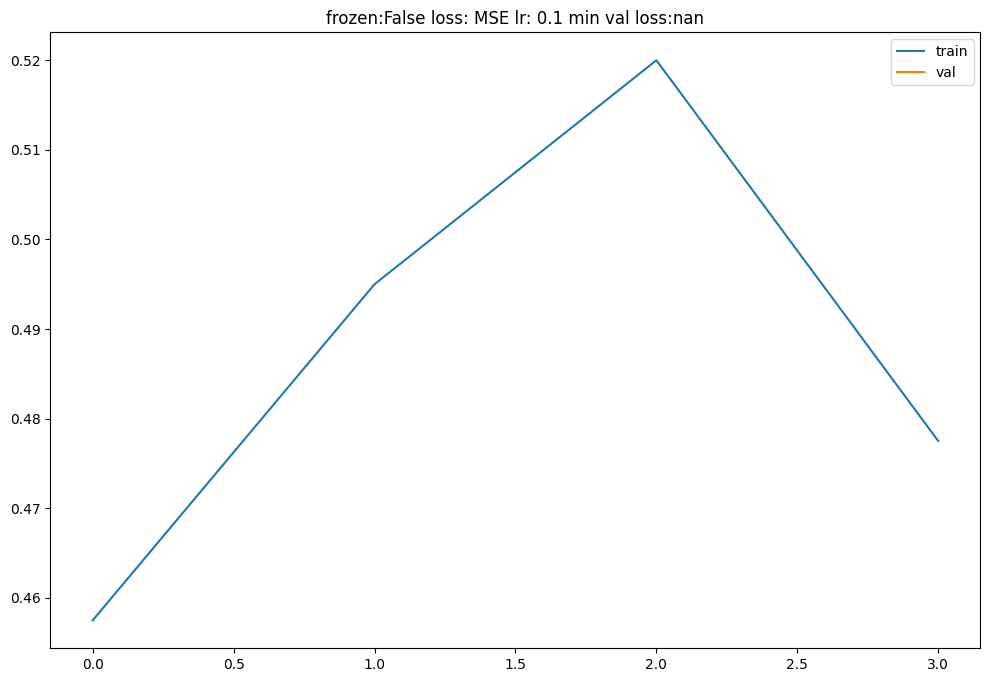

  0%|          | 0/25 [00:00<?, ?it/s]

[  1/ 25]	train loss: nan	val loss: nan
[  2/ 25]	train loss: nan	val loss: nan
[  3/ 25]	train loss: nan	val loss: nan
[  4/ 25]	train loss: nan	val loss: nan
[  5/ 25]	train loss: nan	val loss: nan
[  6/ 25]	train loss: nan	val loss: nan
[  7/ 25]	train loss: nan	val loss: nan
[  8/ 25]	train loss: nan	val loss: nan
[  9/ 25]	train loss: nan	val loss: nan
[ 10/ 25]	train loss: nan	val loss: nan
[ 11/ 25]	train loss: nan	val loss: nan
[ 12/ 25]	train loss: nan	val loss: nan
[ 13/ 25]	train loss: nan	val loss: nan
[ 14/ 25]	train loss: nan	val loss: nan
[ 15/ 25]	train loss: nan	val loss: nan
[ 16/ 25]	train loss: nan	val loss: nan
[ 17/ 25]	train loss: nan	val loss: nan
[ 18/ 25]	train loss: nan	val loss: nan
[ 19/ 25]	train loss: nan	val loss: nan
[ 20/ 25]	train loss: nan	val loss: nan
[ 21/ 25]	train loss: nan	val loss: nan
[ 22/ 25]	train loss: nan	val loss: nan
[ 23/ 25]	train loss: nan	val loss: nan
[ 24/ 25]	train loss: nan	val loss: nan
[ 25/ 25]	train loss: nan	val loss: nan


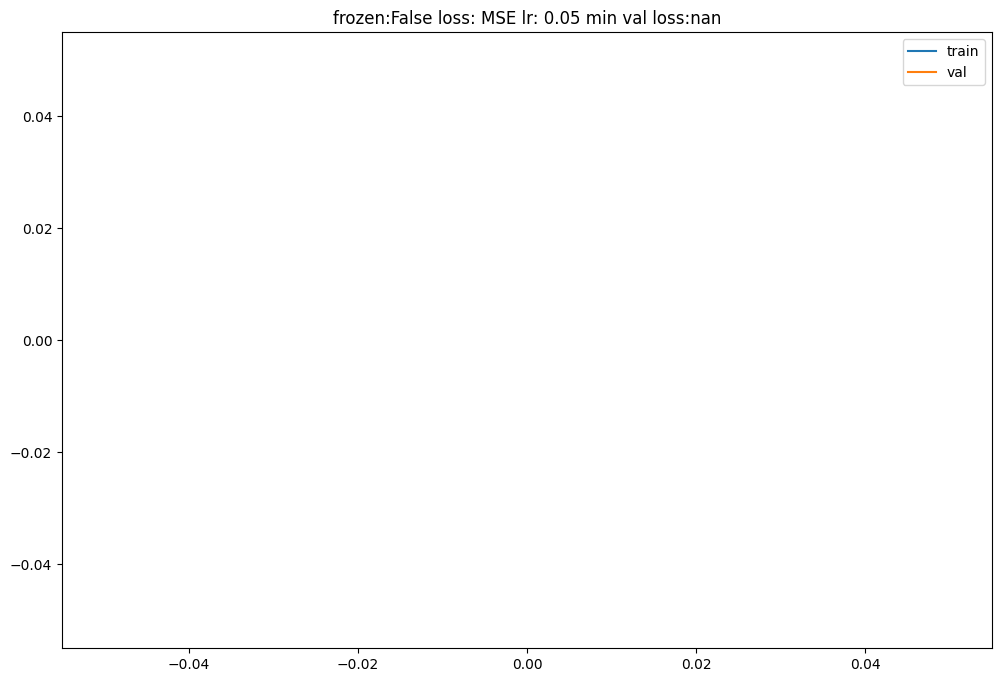

  0%|          | 0/25 [00:00<?, ?it/s]

[  1/ 25]	train loss: nan	val loss: nan
[  2/ 25]	train loss: nan	val loss: nan
[  3/ 25]	train loss: nan	val loss: nan
[  4/ 25]	train loss: nan	val loss: nan
[  5/ 25]	train loss: nan	val loss: nan
[  6/ 25]	train loss: nan	val loss: nan
[  7/ 25]	train loss: nan	val loss: nan
[  8/ 25]	train loss: nan	val loss: nan
[  9/ 25]	train loss: nan	val loss: nan
[ 10/ 25]	train loss: nan	val loss: nan
[ 11/ 25]	train loss: nan	val loss: nan
[ 12/ 25]	train loss: nan	val loss: nan
[ 13/ 25]	train loss: nan	val loss: nan
[ 14/ 25]	train loss: nan	val loss: nan
[ 15/ 25]	train loss: nan	val loss: nan
[ 16/ 25]	train loss: nan	val loss: nan
[ 17/ 25]	train loss: nan	val loss: nan
[ 18/ 25]	train loss: nan	val loss: nan
[ 19/ 25]	train loss: nan	val loss: nan
[ 20/ 25]	train loss: nan	val loss: nan
[ 21/ 25]	train loss: nan	val loss: nan
[ 22/ 25]	train loss: nan	val loss: nan
[ 23/ 25]	train loss: nan	val loss: nan
[ 24/ 25]	train loss: nan	val loss: nan
[ 25/ 25]	train loss: nan	val loss: nan


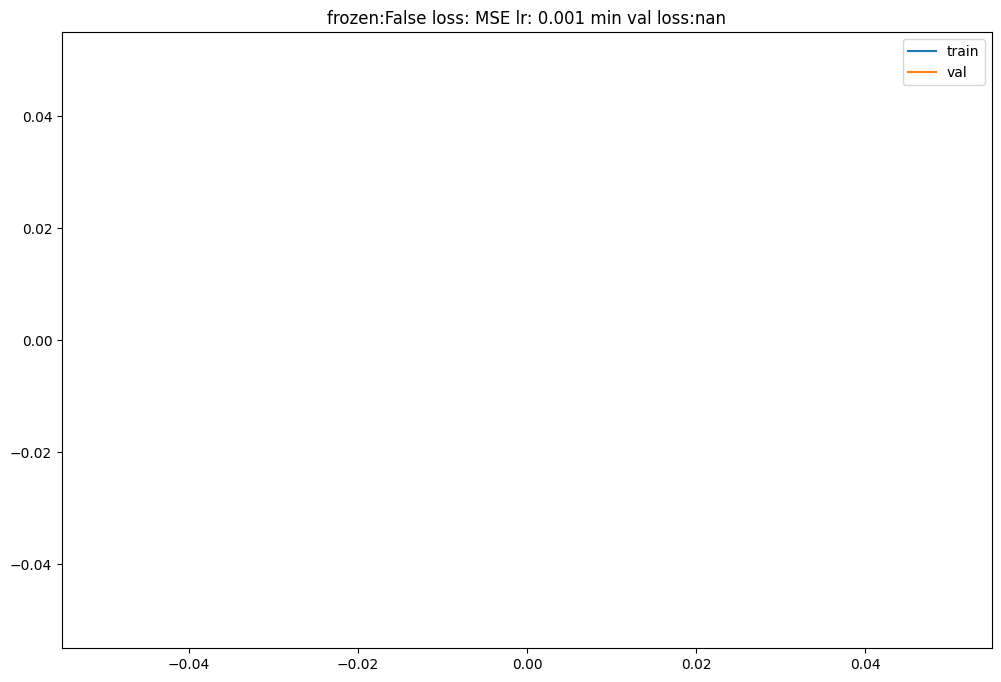

  0%|          | 0/25 [00:00<?, ?it/s]

[  1/ 25]	train loss: nan	val loss: nan
[  2/ 25]	train loss: nan	val loss: nan
[  3/ 25]	train loss: nan	val loss: nan
[  4/ 25]	train loss: nan	val loss: nan
[  5/ 25]	train loss: nan	val loss: nan
[  6/ 25]	train loss: nan	val loss: nan
[  7/ 25]	train loss: nan	val loss: nan
[  8/ 25]	train loss: nan	val loss: nan
[  9/ 25]	train loss: nan	val loss: nan
[ 10/ 25]	train loss: nan	val loss: nan
[ 11/ 25]	train loss: nan	val loss: nan
[ 12/ 25]	train loss: nan	val loss: nan
[ 13/ 25]	train loss: nan	val loss: nan
[ 14/ 25]	train loss: nan	val loss: nan
[ 15/ 25]	train loss: nan	val loss: nan
[ 16/ 25]	train loss: nan	val loss: nan
[ 17/ 25]	train loss: nan	val loss: nan
[ 18/ 25]	train loss: nan	val loss: nan
[ 19/ 25]	train loss: nan	val loss: nan
[ 20/ 25]	train loss: nan	val loss: nan
[ 21/ 25]	train loss: nan	val loss: nan
[ 22/ 25]	train loss: nan	val loss: nan
[ 23/ 25]	train loss: nan	val loss: nan
[ 24/ 25]	train loss: nan	val loss: nan
[ 25/ 25]	train loss: nan	val loss: nan


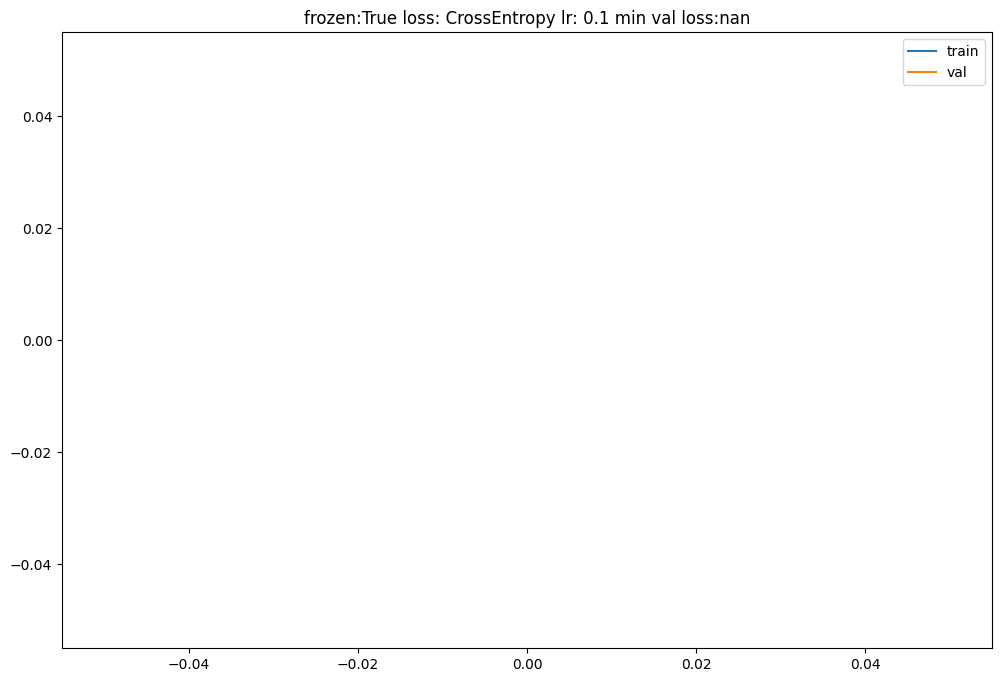

  0%|          | 0/25 [00:00<?, ?it/s]

[  1/ 25]	train loss: nan	val loss: nan
[  2/ 25]	train loss: nan	val loss: nan
[  3/ 25]	train loss: nan	val loss: nan
[  4/ 25]	train loss: nan	val loss: nan
[  5/ 25]	train loss: nan	val loss: nan
[  6/ 25]	train loss: nan	val loss: nan
[  7/ 25]	train loss: nan	val loss: nan
[  8/ 25]	train loss: nan	val loss: nan
[  9/ 25]	train loss: nan	val loss: nan
[ 10/ 25]	train loss: nan	val loss: nan
[ 11/ 25]	train loss: nan	val loss: nan
[ 12/ 25]	train loss: nan	val loss: nan
[ 13/ 25]	train loss: nan	val loss: nan
[ 14/ 25]	train loss: nan	val loss: nan
[ 15/ 25]	train loss: nan	val loss: nan
[ 16/ 25]	train loss: nan	val loss: nan
[ 17/ 25]	train loss: nan	val loss: nan
[ 18/ 25]	train loss: nan	val loss: nan
[ 19/ 25]	train loss: nan	val loss: nan
[ 20/ 25]	train loss: nan	val loss: nan
[ 21/ 25]	train loss: nan	val loss: nan
[ 22/ 25]	train loss: nan	val loss: nan
[ 23/ 25]	train loss: nan	val loss: nan
[ 24/ 25]	train loss: nan	val loss: nan
[ 25/ 25]	train loss: nan	val loss: nan


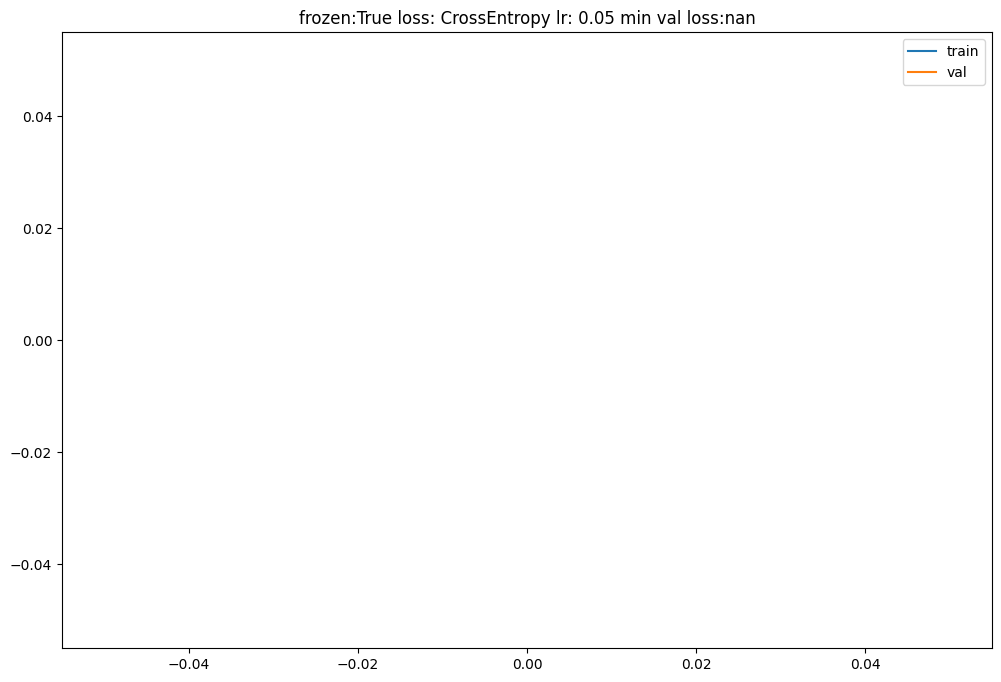

  0%|          | 0/25 [00:00<?, ?it/s]

[  1/ 25]	train loss: nan	val loss: nan
[  2/ 25]	train loss: nan	val loss: nan
[  3/ 25]	train loss: nan	val loss: nan
[  4/ 25]	train loss: nan	val loss: nan
[  5/ 25]	train loss: nan	val loss: nan
[  6/ 25]	train loss: nan	val loss: nan
[  7/ 25]	train loss: nan	val loss: nan
[  8/ 25]	train loss: nan	val loss: nan
[  9/ 25]	train loss: nan	val loss: nan
[ 10/ 25]	train loss: nan	val loss: nan
[ 11/ 25]	train loss: nan	val loss: nan
[ 12/ 25]	train loss: nan	val loss: nan
[ 13/ 25]	train loss: nan	val loss: nan
[ 14/ 25]	train loss: nan	val loss: nan
[ 15/ 25]	train loss: nan	val loss: nan
[ 16/ 25]	train loss: nan	val loss: nan
[ 17/ 25]	train loss: nan	val loss: nan
[ 18/ 25]	train loss: nan	val loss: nan
[ 19/ 25]	train loss: nan	val loss: nan
[ 20/ 25]	train loss: nan	val loss: nan
[ 21/ 25]	train loss: nan	val loss: nan
[ 22/ 25]	train loss: nan	val loss: nan
[ 23/ 25]	train loss: nan	val loss: nan
[ 24/ 25]	train loss: nan	val loss: nan
[ 25/ 25]	train loss: nan	val loss: nan


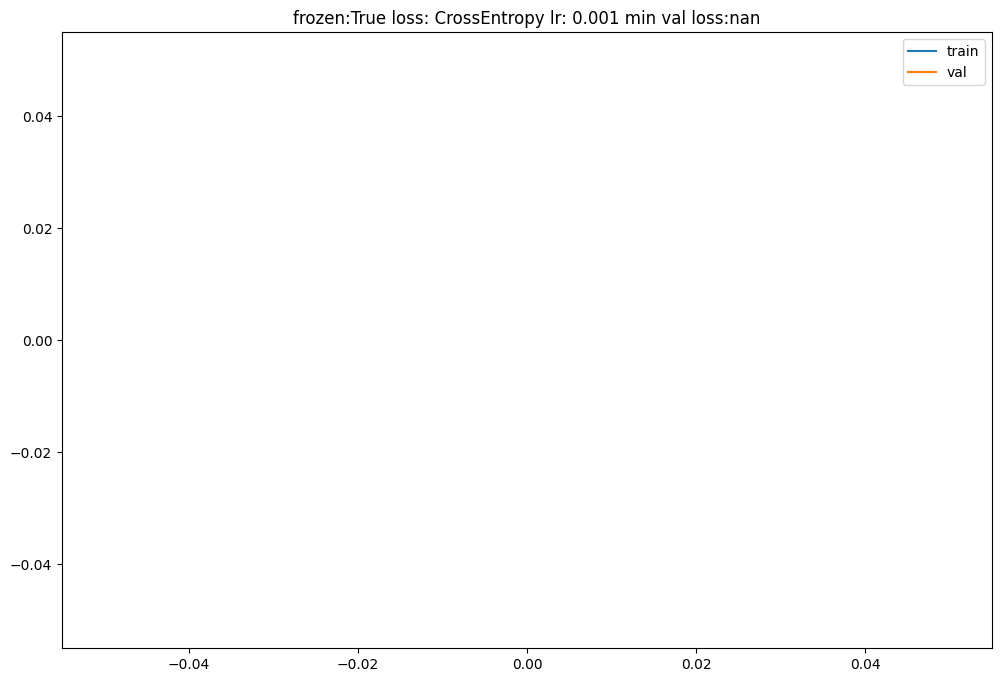

  0%|          | 0/25 [00:00<?, ?it/s]

[  1/ 25]	train loss: nan	val loss: nan
[  2/ 25]	train loss: nan	val loss: nan
[  3/ 25]	train loss: nan	val loss: nan
[  4/ 25]	train loss: nan	val loss: nan
[  5/ 25]	train loss: nan	val loss: nan
[  6/ 25]	train loss: nan	val loss: nan
[  7/ 25]	train loss: nan	val loss: nan
[  8/ 25]	train loss: nan	val loss: nan
[  9/ 25]	train loss: nan	val loss: nan
[ 10/ 25]	train loss: nan	val loss: nan
[ 11/ 25]	train loss: nan	val loss: nan
[ 12/ 25]	train loss: nan	val loss: nan
[ 13/ 25]	train loss: nan	val loss: nan
[ 14/ 25]	train loss: nan	val loss: nan
[ 15/ 25]	train loss: nan	val loss: nan
[ 16/ 25]	train loss: nan	val loss: nan
[ 17/ 25]	train loss: nan	val loss: nan
[ 18/ 25]	train loss: nan	val loss: nan
[ 19/ 25]	train loss: nan	val loss: nan
[ 20/ 25]	train loss: nan	val loss: nan
[ 21/ 25]	train loss: nan	val loss: nan
[ 22/ 25]	train loss: nan	val loss: nan
[ 23/ 25]	train loss: nan	val loss: nan
[ 24/ 25]	train loss: nan	val loss: nan
[ 25/ 25]	train loss: nan	val loss: nan


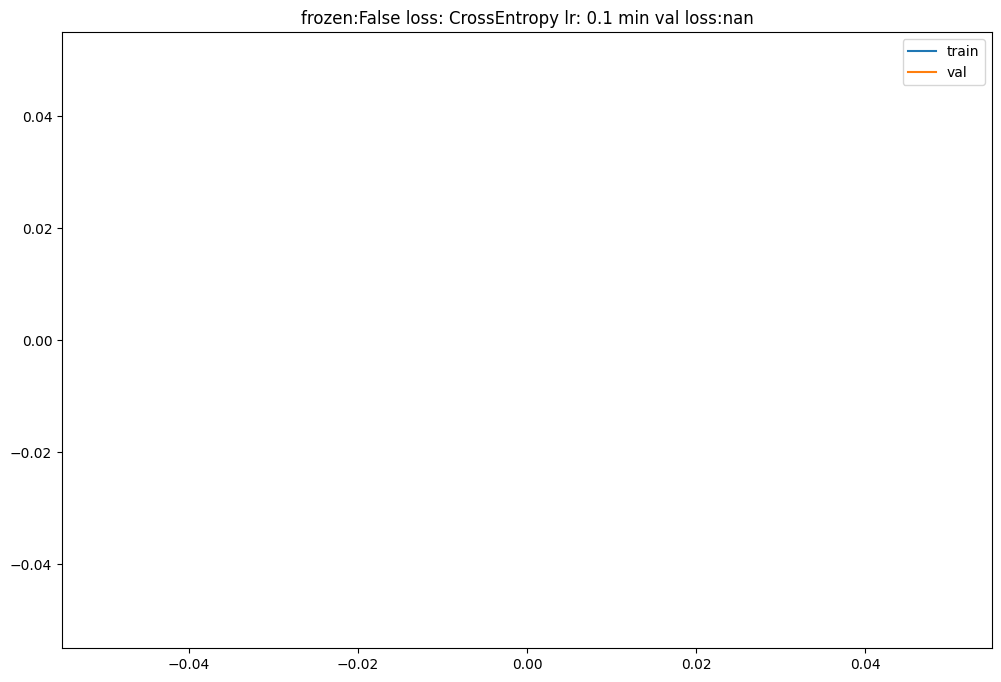

  0%|          | 0/25 [00:00<?, ?it/s]

[  1/ 25]	train loss: nan	val loss: nan
[  2/ 25]	train loss: nan	val loss: nan
[  3/ 25]	train loss: nan	val loss: nan
[  4/ 25]	train loss: nan	val loss: nan
[  5/ 25]	train loss: nan	val loss: nan
[  6/ 25]	train loss: nan	val loss: nan
[  7/ 25]	train loss: nan	val loss: nan
[  8/ 25]	train loss: nan	val loss: nan
[  9/ 25]	train loss: nan	val loss: nan
[ 10/ 25]	train loss: nan	val loss: nan
[ 11/ 25]	train loss: nan	val loss: nan
[ 12/ 25]	train loss: nan	val loss: nan
[ 13/ 25]	train loss: nan	val loss: nan
[ 14/ 25]	train loss: nan	val loss: nan
[ 15/ 25]	train loss: nan	val loss: nan
[ 16/ 25]	train loss: nan	val loss: nan
[ 17/ 25]	train loss: nan	val loss: nan
[ 18/ 25]	train loss: nan	val loss: nan
[ 19/ 25]	train loss: nan	val loss: nan
[ 20/ 25]	train loss: nan	val loss: nan
[ 21/ 25]	train loss: nan	val loss: nan
[ 22/ 25]	train loss: nan	val loss: nan
[ 23/ 25]	train loss: nan	val loss: nan
[ 24/ 25]	train loss: nan	val loss: nan
[ 25/ 25]	train loss: nan	val loss: nan


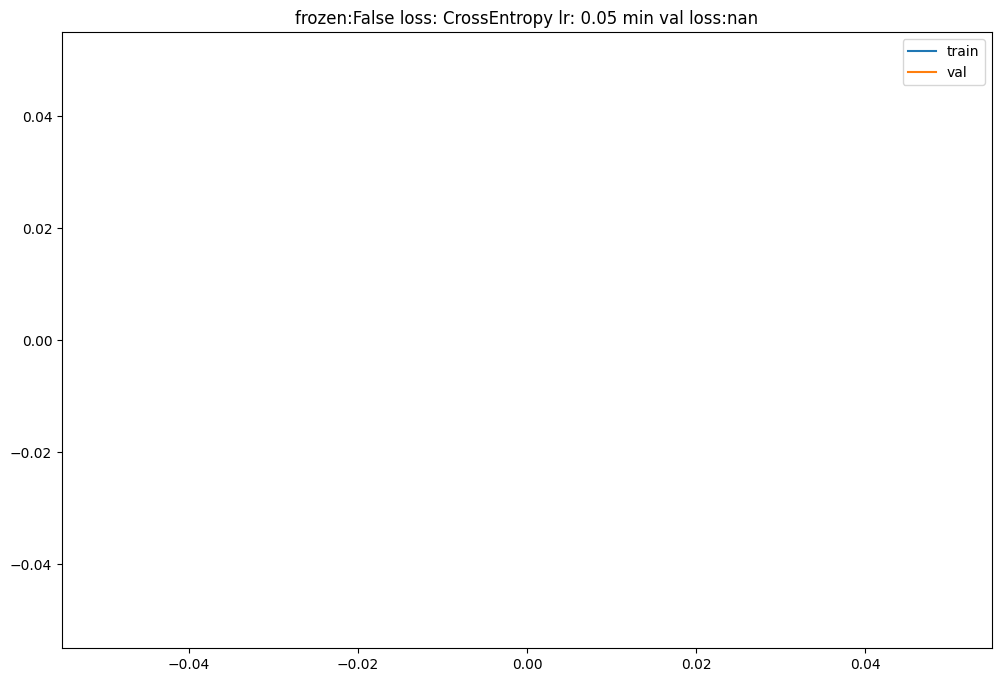

  0%|          | 0/25 [00:00<?, ?it/s]

[  1/ 25]	train loss: nan	val loss: nan
[  2/ 25]	train loss: nan	val loss: nan
[  3/ 25]	train loss: nan	val loss: nan
[  4/ 25]	train loss: nan	val loss: nan
[  5/ 25]	train loss: nan	val loss: nan
[  6/ 25]	train loss: nan	val loss: nan
[  7/ 25]	train loss: nan	val loss: nan
[  8/ 25]	train loss: nan	val loss: nan
[  9/ 25]	train loss: nan	val loss: nan
[ 10/ 25]	train loss: nan	val loss: nan
[ 11/ 25]	train loss: nan	val loss: nan
[ 12/ 25]	train loss: nan	val loss: nan
[ 13/ 25]	train loss: nan	val loss: nan
[ 14/ 25]	train loss: nan	val loss: nan
[ 15/ 25]	train loss: nan	val loss: nan
[ 16/ 25]	train loss: nan	val loss: nan
[ 17/ 25]	train loss: nan	val loss: nan
[ 18/ 25]	train loss: nan	val loss: nan
[ 19/ 25]	train loss: nan	val loss: nan
[ 20/ 25]	train loss: nan	val loss: nan
[ 21/ 25]	train loss: nan	val loss: nan
[ 22/ 25]	train loss: nan	val loss: nan
[ 23/ 25]	train loss: nan	val loss: nan
[ 24/ 25]	train loss: nan	val loss: nan
[ 25/ 25]	train loss: nan	val loss: nan


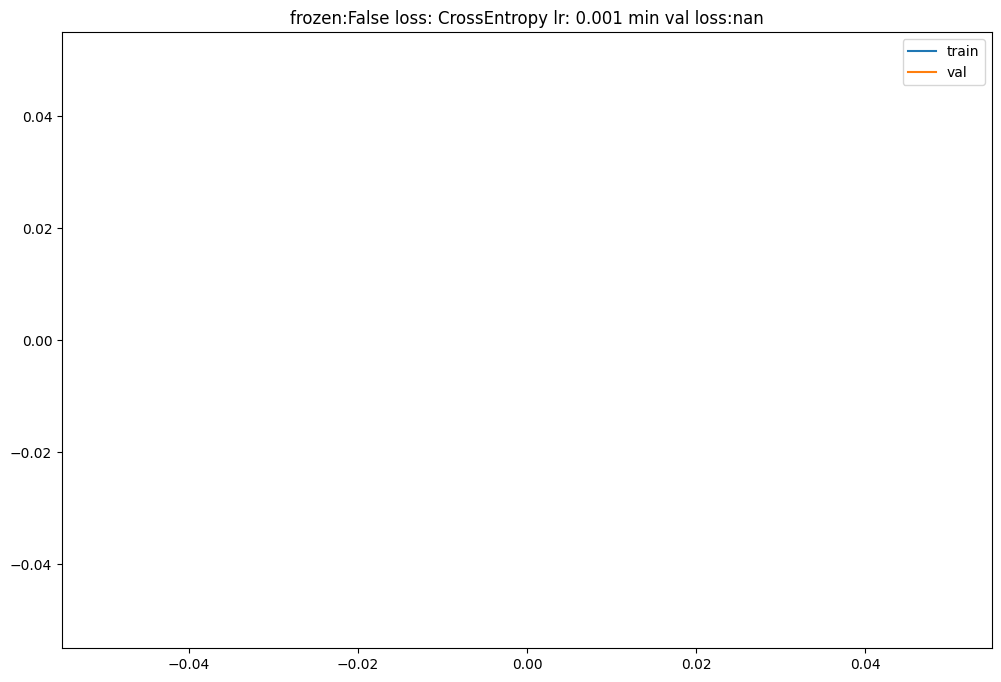

In [ ]:
loss_functions = [mse_loss, bce_loss]
frozen = [True, False]
lr = [0.1, 0.05, 0.001]

temp = dict()

for lf, fr, learning_rate in product(loss_functions, frozen, lr):
    vgg19 = torchvision.models.vgg19(torchvision.models.VGG19_Weights.IMAGENET1K_V1)
    model_l = Model(params_list, fr, vgg19)
    history = train(model_l, 25, lf, fr, learning_rate)
    arg2 = "MSE" if isinstance(lf, torch.nn.modules.loss.MSELoss) else "CrossEntropy"
    min_loss = min(history["val"])
    title = f'frozen:{fr} loss: {arg2} lr: {learning_rate} min val loss:{min_loss}'
    temp[title] = history
    with open('results.json', 'w') as fp:
        json.dump(temp, fp
    plot_history(history, title = title)
